# Minimum viable product

In [1]:
import os
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras.datasets.mnist as mnist

from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, MaxPool2D, Conv2DTranspose, Reshape, Flatten, Activation, LeakyReLU
from tensorflow.keras.activations import relu, sigmoid, softmax
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import BinaryCrossentropy, Accuracy, AUC

## GAN

Build the generator model.

In [2]:
def build_generator(img_shape, z_dim):
    model = Sequential()
    model.add(Dense(128, input_shape=z_dim))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))
    return model

Build the discriminator model.

In [3]:
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1, activation='sigmoid'))
    return model

Build the GAN model.

In [4]:
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

Compile the model.

In [5]:
img_shape = (28, 28, 1)
z_dim = (100, )

discriminator = build_discriminator(img_shape)

discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

generator = build_generator(img_shape, z_dim)

discriminator.trainable = False

gan = build_gan(generator, discriminator)

gan.compile(loss='binary_crossentropy',
            optimizer=Adam())

Train model.

In [6]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):

    (X_train, _), (_, _) = mnist.load_data()

    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for iteration in tqdm(range(iterations)):

        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:

            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            sample_images(generator)

Sample generated images.

In [8]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim[0]))

    gen_imgs = generator.predict(z)
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

    plt.show()

Train GAN and output images every 1000 training rounds.

  5%|▍         | 999/20000 [01:27<27:02, 11.71it/s]1000 [D loss: 0.076766, acc.: 96.48%] [G loss: 5.890586]


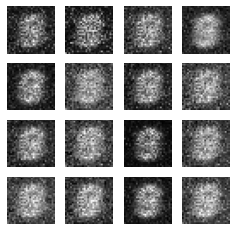

 10%|▉         | 1999/20000 [02:53<23:18, 12.87it/s]2000 [D loss: 0.069691, acc.: 96.88%] [G loss: 6.006162]


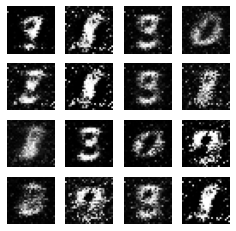

 15%|█▍        | 2999/20000 [04:19<23:39, 11.98it/s]3000 [D loss: 0.140637, acc.: 94.92%] [G loss: 4.030247]


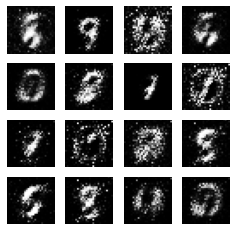

 20%|█▉        | 3999/20000 [05:50<26:40,  9.99it/s]4000 [D loss: 0.225537, acc.: 91.80%] [G loss: 5.810765]


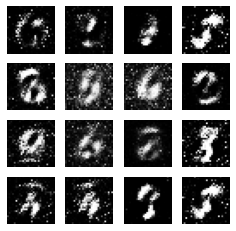

 25%|██▍       | 4998/20000 [07:21<20:56, 11.94it/s]5000 [D loss: 0.515044, acc.: 75.00%] [G loss: 2.673167]


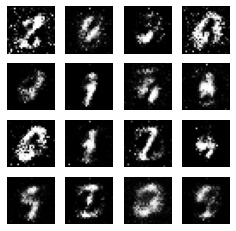

 30%|██▉       | 5999/20000 [08:53<23:11, 10.06it/s]6000 [D loss: 0.470378, acc.: 80.86%] [G loss: 3.703321]


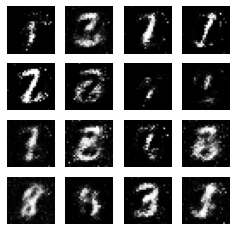

 35%|███▍      | 6999/20000 [10:25<18:10, 11.93it/s]7000 [D loss: 0.514446, acc.: 78.91%] [G loss: 3.054995]


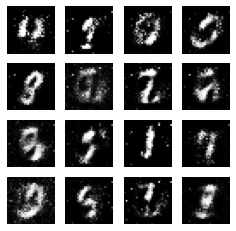

 40%|███▉      | 7999/20000 [11:54<17:07, 11.67it/s]8000 [D loss: 0.386932, acc.: 82.03%] [G loss: 3.178432]


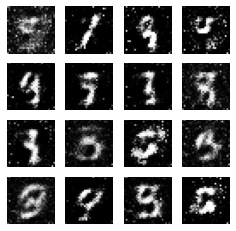

 45%|████▍     | 8999/20000 [13:28<18:51,  9.72it/s]9000 [D loss: 0.342636, acc.: 85.16%] [G loss: 3.272789]


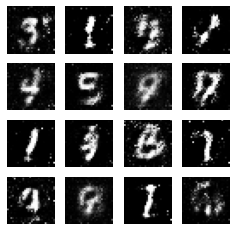

 50%|████▉     | 9998/20000 [14:59<15:11, 10.97it/s]10000 [D loss: 0.460114, acc.: 81.25%] [G loss: 3.410546]


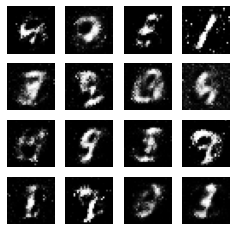

 55%|█████▍    | 10998/20000 [16:28<13:18, 11.28it/s]11000 [D loss: 0.600893, acc.: 71.48%] [G loss: 2.490889]


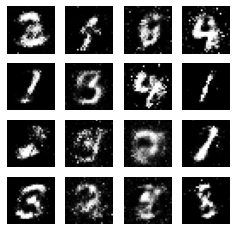

 60%|█████▉    | 11998/20000 [17:59<11:46, 11.32it/s]12000 [D loss: 0.361114, acc.: 84.38%] [G loss: 2.844558]


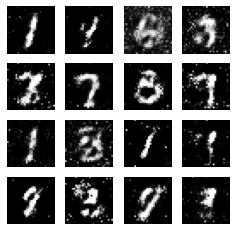

 65%|██████▍   | 12999/20000 [19:35<10:32, 11.07it/s]13000 [D loss: 0.543364, acc.: 75.78%] [G loss: 2.277204]


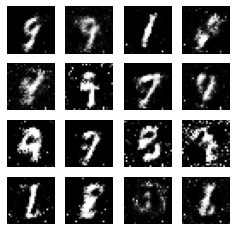

 70%|██████▉   | 13999/20000 [21:11<09:45, 10.24it/s]14000 [D loss: 0.275087, acc.: 89.06%] [G loss: 3.112742]


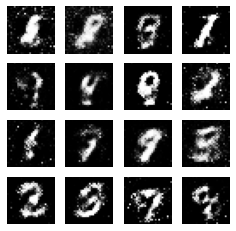

 75%|███████▍  | 14999/20000 [23:02<07:41, 10.84it/s]15000 [D loss: 0.394429, acc.: 85.16%] [G loss: 2.564693]


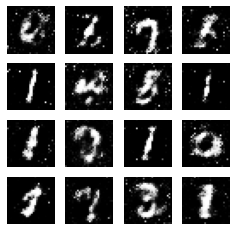

 80%|███████▉  | 15998/20000 [24:35<05:50, 11.41it/s]16000 [D loss: 0.469084, acc.: 78.52%] [G loss: 2.579747]


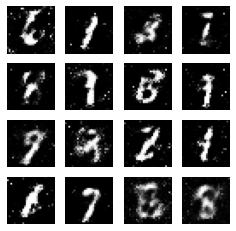

 85%|████████▍ | 16999/20000 [26:09<06:15,  7.99it/s]17000 [D loss: 0.474087, acc.: 80.47%] [G loss: 2.120199]


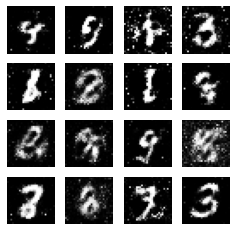

 90%|████████▉ | 17999/20000 [27:50<03:16, 10.19it/s]18000 [D loss: 0.524499, acc.: 76.17%] [G loss: 2.386963]


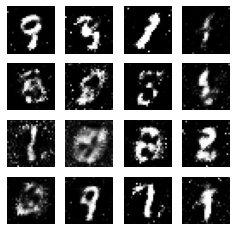

 95%|█████████▍| 18999/20000 [29:37<01:44,  9.55it/s]19000 [D loss: 0.214108, acc.: 91.80%] [G loss: 3.176380]


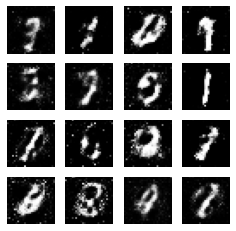

100%|█████████▉| 19999/20000 [31:21<00:00,  8.62it/s]20000 [D loss: 0.307713, acc.: 86.72%] [G loss: 2.993068]


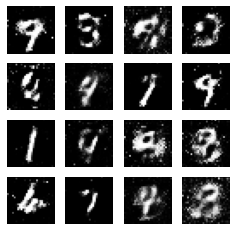

100%|██████████| 20000/20000 [31:22<00:00, 10.62it/s]


In [10]:
iterations = 20000
batch_size = 128
sample_interval = 1000

train(iterations, batch_size, sample_interval)

## DCGAN

We are able to use convolutional neural networks (CNNs) within the disciminator and generator networks for better results.

In [2]:
def build_generator(z_dim):

    model = Sequential()

    # Reshape input into 7x7x256 tensor via a fully connected layer
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))

    # Transposed convolution layer, from 7x7x256 into 14x14x128 tensor
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Transposed convolution layer, from 14x14x128 to 14x14x64 tensor
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Transposed convolution layer, from 14x14x64 to 28x28x1 tensor
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))

    # Output layer with tanh activation
    model.add(Activation('tanh'))

    return model

In [3]:
def build_discriminator(img_shape):

    model = Sequential()

    # Convolutional layer, from 28x28x1 into 14x14x32 tensor
    model.add(
        Conv2D(32,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 14x14x32 into 7x7x64 tensor
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 7x7x64 tensor into 3x3x128 tensor
    model.add(
        Conv2D(128,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Output layer with sigmoid activation
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [4]:
def build_gan(generator, discriminator):

    model = Sequential()

    # Combined Generator -> Discriminator model
    model.add(generator)
    model.add(discriminator)

    return model

In [6]:
img_shape = (28, 28, 1)
z_dim = 100

# Build and compile the Discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

# Build the Generator
generator = build_generator(z_dim)

# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [7]:
losses = []
accuracies = []
iteration_checkpoints = []

def train_dcgan(iterations, batch_size, sample_interval):

    # Load the MNIST dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale [0, 255] grayscale pixel values to [-1, 1]
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))

    for iteration in tqdm(range(iterations)):

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        print(f"{iteration}: here A")

        # Get a random batch of real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        print(f"{iteration}: here B")

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        print(f"{iteration}: here C")

        # Train Discriminator
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        print(f"{iteration}: here D")

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        print(f"{iteration}: here E")

        # Train Generator
        g_loss = gan.train_on_batch(z, real)

        print(f"{iteration}: here F")

        if (iteration + 1) % sample_interval == 0:

            print(f"{iteration}: here AA")

            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            print(f"{iteration}: here BB")

            # Output a sample of generated image
            sample_images(generator)

            print(f"{iteration}: here CC")

        print(f"{iteration}: END")


In [8]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise
    gen_imgs = generator.predict(z)

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

In [10]:
# Set hyperparameters
iterations = 20000
batch_size = 128
sample_interval = 1000

# Train the DCGAN for the specified number of iterations
train_dcgan(iterations, batch_size, sample_interval)

  0%|          | 0/20000 [00:00<?, ?it/s]